In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix


In [2]:
cancer = load_breast_cancer()
X= cancer.data
y = cancer.target
#split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=170, train_size=399, random_state=42)

print (X.shape)
print (X_test.shape)
print (y_train.shape)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print("Komponen training dataset: {}" .format(Counter(y_train)))
print("Komponen testing dataset: {}" .format(Counter(y_test)))
print("Komponen dataset: {}" .format(Counter(y)))

(569, 30)
(170, 30)
(399,)
Komponen training dataset: Counter({1: 250, 0: 149})
Komponen testing dataset: Counter({1: 107, 0: 63})
Komponen dataset: Counter({1: 357, 0: 212})


In [3]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [4]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.04
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [5]:
#implement undersampling Edited Nearest Neighbor
print ("Komponen dataset sebelum undersampling: {} " .format(Counter(y_train)))
# sampler = EditedNearestNeighbours(random_state = 42 , sampling_strategy='majority')
sampler = NearMiss(version=1, sampling_strategy=0.9, n_neighbors=5)

X_enn, y_enn = sampler.fit_resample(X_train, y_train)

clf_logreg = LogisticRegression(C=0.1, penalty='l1')
clf_logreg.fit(X_enn,y_enn)

clf_knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn.fit(X_enn, y_enn)

clf_svm = SVC(gamma=1.5, C=1, kernel='rbf')
clf_svm.fit(X_enn, y_enn)

clf_dt = DecisionTreeClassifier(max_depth=5, criterion="entropy")
clf_dt.fit(X_enn, y_enn)

clf_rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto')
clf_rf.fit(X_enn, y_enn)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn)))


Komponen dataset sebelum undersampling: Counter({1: 250, 0: 149}) 
Komponen dataset setelah undersampling = Counter({1: 165, 0: 149})


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [6]:
print (clf_dt.feature_importances_)

[0.         0.05475897 0.         0.         0.         0.
 0.         0.62503474 0.         0.01794407 0.         0.
 0.03436313 0.         0.         0.         0.         0.
 0.         0.         0.06283155 0.05200905 0.         0.01581048
 0.         0.         0.01769292 0.09594541 0.         0.02360969]


['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']

^
Expected {'graph' | 'digraph'} (at char 0), (line:1, col:1)


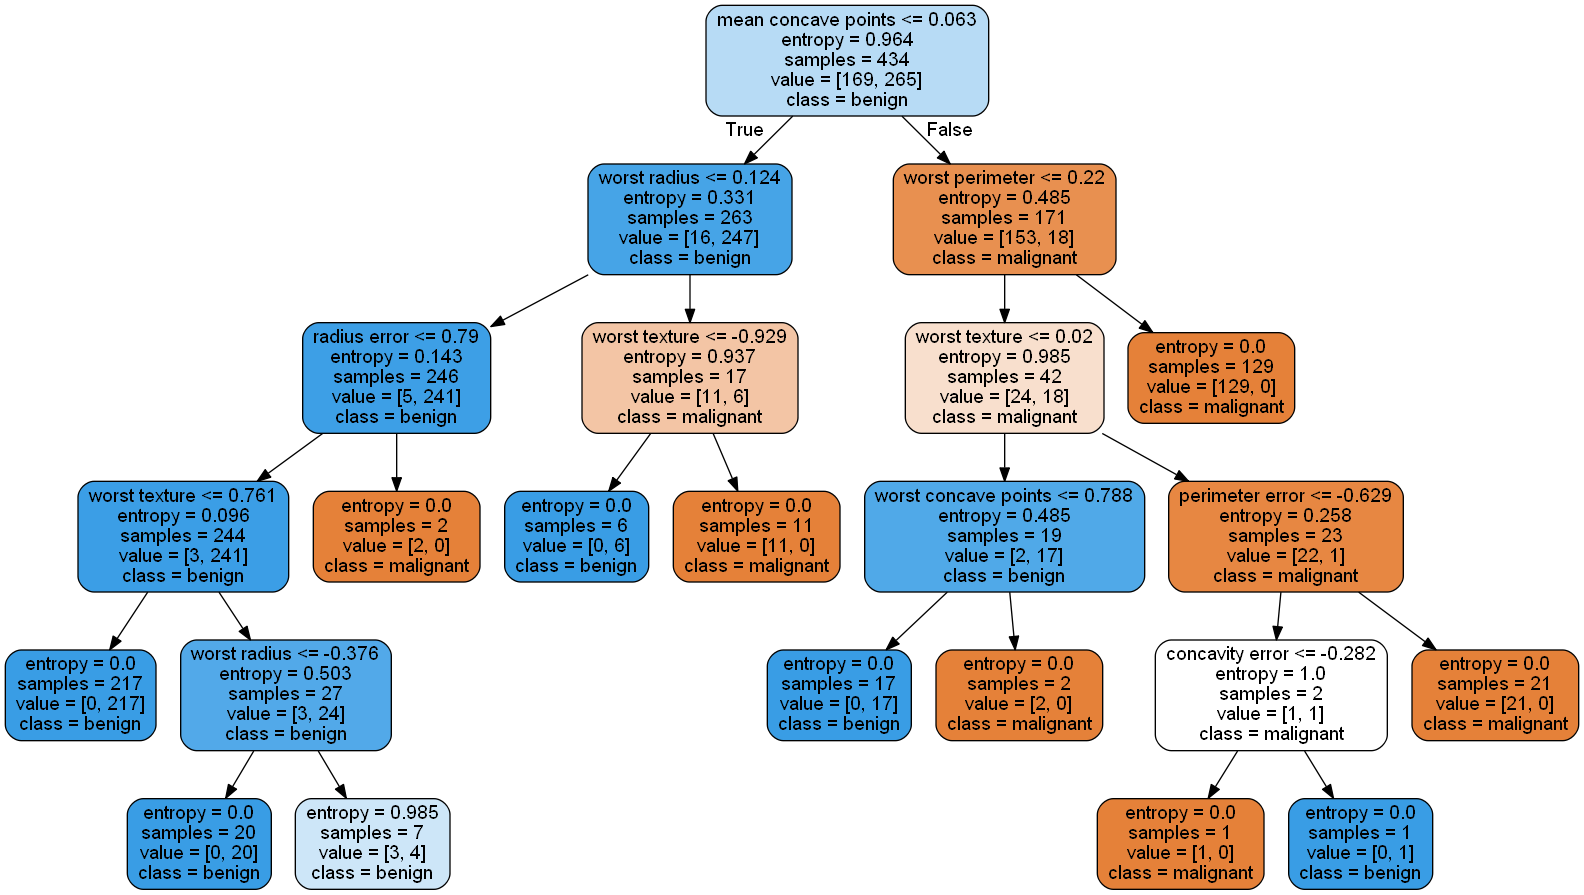

In [7]:

#Draw the tree
print (cancer.feature_names)
print(cancer.target_names)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz (clf_dt, out_file='tree_breast_cancer_enn.dot',
                 feature_names=cancer.feature_names, class_names=cancer.target_names,
                rounded=True, proportion=False, precision=3, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(filename = 'tree_breast_cancer_enn.png')
#command to convert dot to png
# dot -Tpng file.dot -o file.png

In [8]:
print ("Pengukuran Performa terhadap Training Set Set: \n")

names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]
# clf = (clf_logreg,clf_knn, clf_svm, clf_dt,clf_rf)
for classifiers, name in zip ((clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf), names):
    print ("\nHasil klasifikasi training set {}: " .format(name))
    y_pred = classifiers.predict(X_enn)
    conf_matrix_train = confusion_matrix(y_enn, y_pred)
    print (conf_matrix_train)
    print(classification_report(y_enn, y_pred))
    G_mean = geometric_mean_score (y_enn, y_pred)
    print ("G-Mean untuk {} : "  .format(name) , G_mean)


Pengukuran Performa terhadap Training Set Set: 


Hasil klasifikasi training set Logistic Regression: 
[[142   7]
 [  4 161]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       149
           1       0.96      0.98      0.97       165

   micro avg       0.96      0.96      0.96       314
   macro avg       0.97      0.96      0.96       314
weighted avg       0.97      0.96      0.96       314

G-Mean untuk Logistic Regression :  0.9643218424481819

Hasil klasifikasi training set K-Nearest Neighbours: 
[[144   5]
 [  0 165]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       149
           1       0.97      1.00      0.99       165

   micro avg       0.98      0.98      0.98       314
   macro avg       0.99      0.98      0.98       314
weighted avg       0.98      0.98      0.98       314

G-Mean untuk K-Nearest Neighbours :  0.9830783046228486

Hasil klasifikasi training set

In [9]:
print ("Pengukuran Performa terhadap Testing Set: \n")

names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]
# clf = (clf_logreg,clf_knn, clf_svm, clf_dt,clf_rf)
    
for classifiers, name in zip ((clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf), names):
    print ("\nHasil klasifikasi testing set {}: " .format(name))
    y_pred = classifiers.predict(X_test)
    print (X_test.shape)
    conf_matrix_train = confusion_matrix(y_test, y_pred)
    print (conf_matrix_train)

    print(classification_report(y_test, y_pred))
    G_mean = geometric_mean_score (y_test, y_pred)
    print ("G-Mean untuk {} : "  .format(name) , G_mean)



Pengukuran Performa terhadap Testing Set: 


Hasil klasifikasi testing set Logistic Regression: 
(170, 30)
[[ 62   1]
 [  5 102]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        63
           1       0.99      0.95      0.97       107

   micro avg       0.96      0.96      0.96       170
   macro avg       0.96      0.97      0.96       170
weighted avg       0.97      0.96      0.96       170

G-Mean untuk Logistic Regression :  0.9685761414974352

Hasil klasifikasi testing set K-Nearest Neighbours: 
(170, 30)
[[ 59   4]
 [  4 103]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        63
           1       0.96      0.96      0.96       107

   micro avg       0.95      0.95      0.95       170
   macro avg       0.95      0.95      0.95       170
weighted avg       0.95      0.95      0.95       170

G-Mean untuk K-Nearest Neighbours :  0.9494726399542319

Hasil klasifikasi

C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


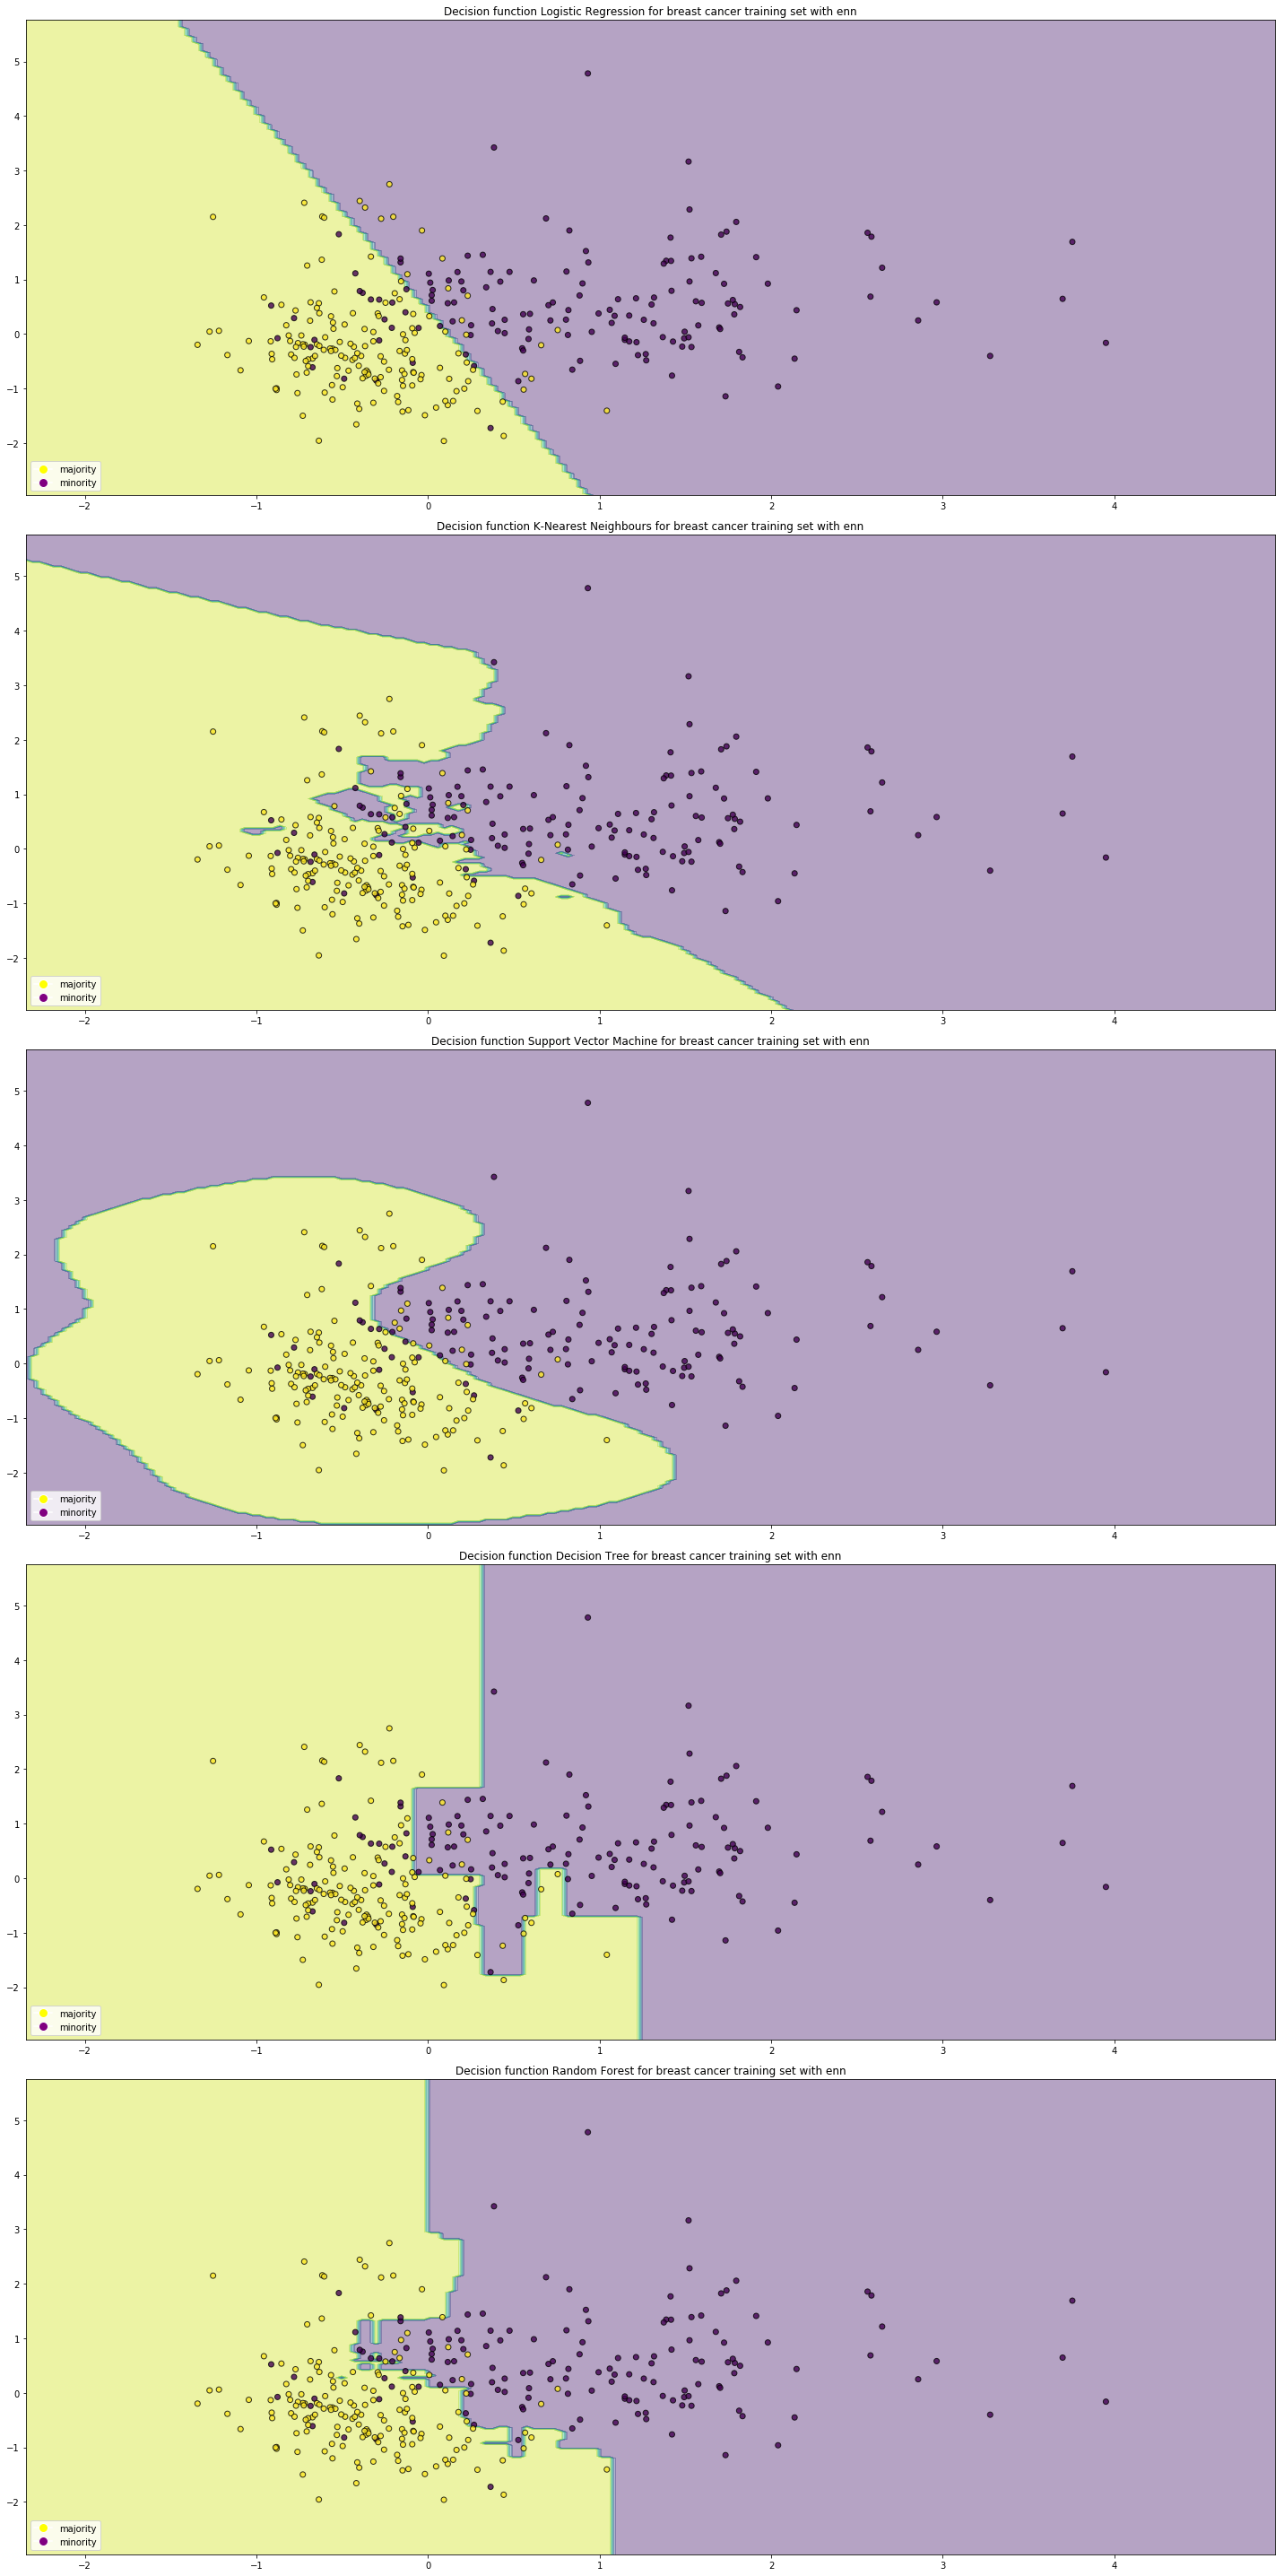

In [10]:
fig, ((ax1),(ax2),(ax3),(ax4),(ax5)) = plt.subplots(5, figsize = (20,40))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1), (ax2), (ax3), (ax4), (ax5))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]

X_enn = X_enn[:,:2]

for ax, name, classifier in zip (ax_arr, names,  (clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf)):
    classifier.fit(X_enn,y_enn)
    
    plot_decision_function(X_enn, y_enn, classifier, ax)
    ax.set_title('Decision function {} for breast cancer training set with enn'.format(name))
    majority=Line2D([], [], color="w", markerfacecolor='yellow', marker='o', label='majority', markersize=10)
    minority=Line2D([], [], color="w", markerfacecolor='purple', marker='o', label='minority', markersize=10)
    ax.legend(handles=[majority,minority], loc='lower left', frameon=True)
fig.tight_layout()
plt.savefig("decision function breast cancer training set with enn.pdf")


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


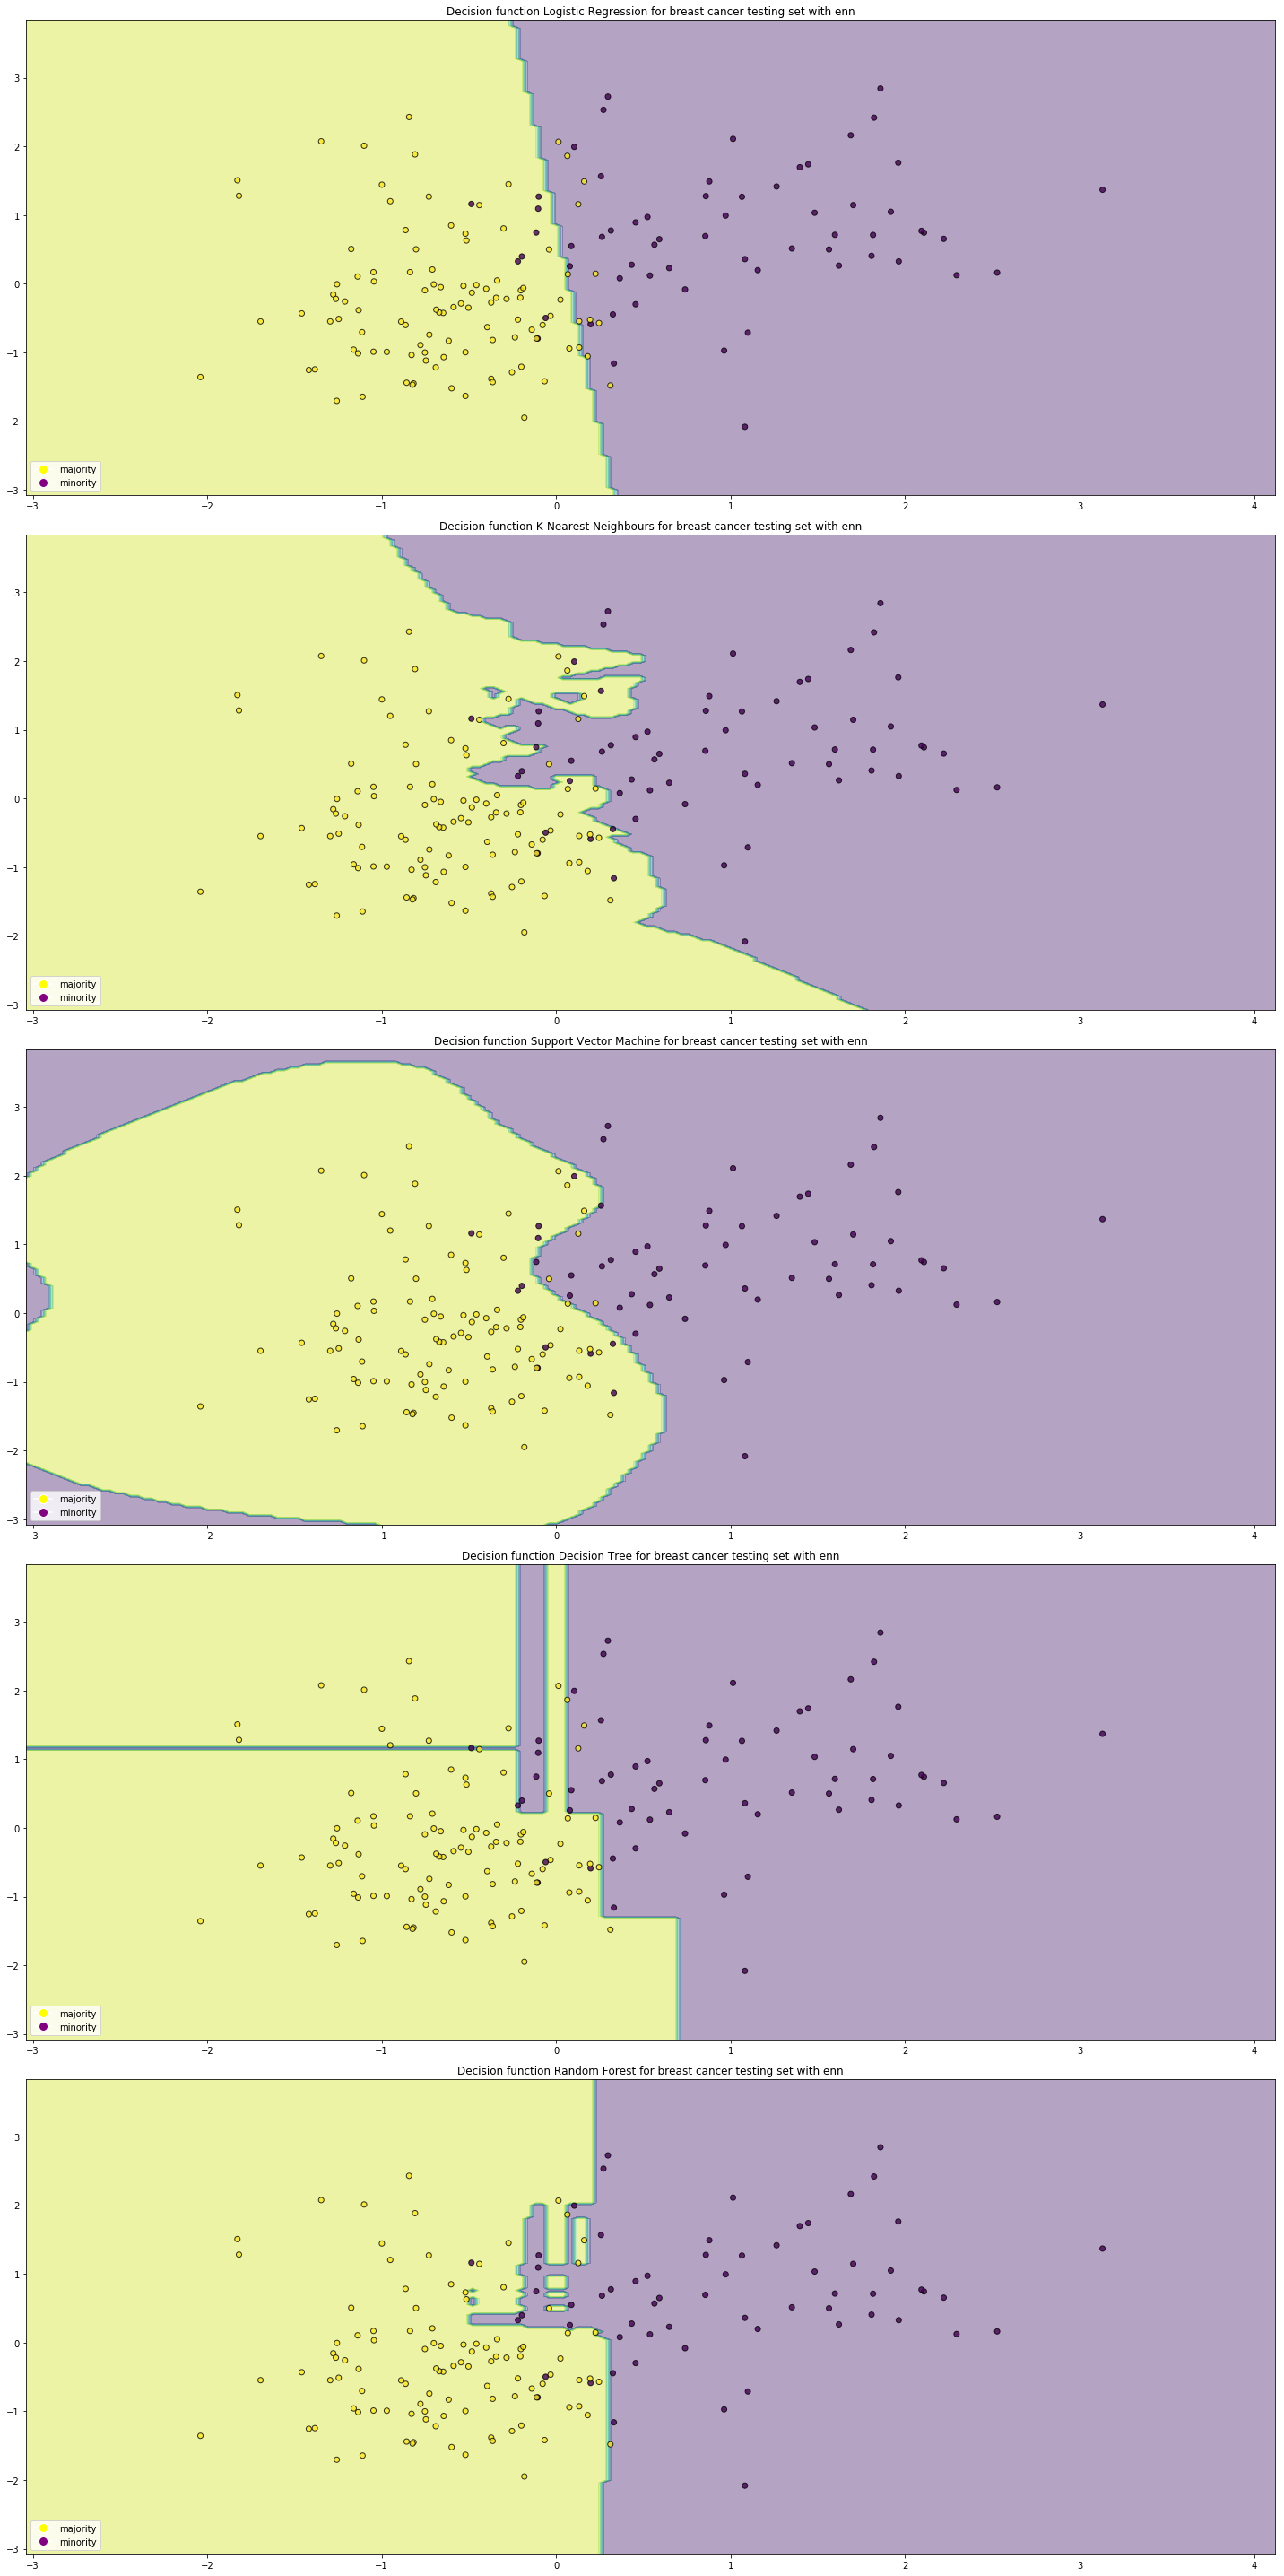

In [11]:
fig, ((ax1),(ax2),(ax3),(ax4),(ax5)) = plt.subplots(5, figsize = (20,40))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1), (ax2), (ax3), (ax4), (ax5))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]

X_test = X_test[:,:2]

for ax, name, classifier in zip (ax_arr, names,  (clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf)):
    classifier.fit(X_test,y_test)
    
    plot_decision_function(X_test, y_test, classifier, ax)
    ax.set_title('Decision function {} for breast cancer testing set with enn'.format(name))
    majority=Line2D([], [], color="w", markerfacecolor='yellow', marker='o', label='majority', markersize=10)
    minority=Line2D([], [], color="w", markerfacecolor='purple', marker='o', label='minority', markersize=10)
    ax.legend(handles=[majority,minority], loc='lower left', frameon=True)
fig.tight_layout()
plt.savefig("decision function breast cancer testing set with enn.pdf")
